In [16]:
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

### Read data

In [50]:
fld_store = "/home/nur/projects/analysis/dynamic_price/data/price_service"
def read_df(x):
    df = pd.read_csv(os.path.join(fld_store, x))
    print("Shape", df.shape)
    df.rename(columns = {'sku_id' : 'SKU'}, inplace=True)
    if 'week_num' in df.columns and 'year' in df.columns: 
        df['year_week'] = df.year.astype(str) + "_" + df.week_num.astype(str)
    display(df.head(2))
    return df

In [51]:
!ls {fld_store}
print("Ex...")
!ls {fld_store}/ex

competitors_price.csv  sales_plan.csv		 transactions.csv
ex		       sku_dict_sample_1000.csv
promo.csv	       stock_purchases.csv
Ex...
ex_batch.csv  ex_feedback.csv  ex_posilki.csv


In [52]:
dfstock = read_df("stock_purchases.csv")

Shape (61252, 5)


,SKU,year,week_num,month,cost_price,year_week
0,10060,2019,1,12,2211.0,2019_1
1,10060,2019,15,4,2454.0,2019_15


In [53]:
dftr = read_df("transactions.csv")

Shape (1334260, 4)


,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0


In [54]:
dfcp = read_df("competitors_price.csv")

Shape (10324, 6)


,year,week_num,SKU,ret_net_1_price,ret_net_2_price,ret_net_3_price,year_week
0,2019,1,10121,2945.681342,2965.743797,2917.394830,2019_1
1,2019,1,10290,949.466060,942.301292,962.799009,2019_1


In [55]:
dfplan = read_df("sales_plan.csv")

Shape (12212, 5)


,SKU,year,month,plan,back_bonus
0,10290,2018,2,20.0,120000
1,10290,2018,3,60.0,140000


In [56]:
dfsku = read_df("sku_dict_sample_1000.csv")

Shape (1000, 9)


,SKU,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,16663,Z8,Z81,Z8100,Z810000,FI3ASO,THSTSG81,2018-06-26,2019-04-21 00:00:00
1,91775,Q5,Q51,Q5100,Q510008,4O4WSH,WKXRWTP7,2019-07-07,2200-01-01 00:00:00


In [57]:
dfpromo = read_df("promo.csv")

Shape (2342, 4)


,SKU,week_num,year,discount,year_week
0,74430,1,2018,0.15,2018_1
1,69978,1,2018,0.05,2018_1


### Data Analysis

In [59]:
dfsku.columns

Index(['SKU', 'fincode', 'ui1_code', 'ui2_code', 'ui3_code', 'vendor',
       'brand_code', 'creation_date', 'expiration_date'],
      dtype='object')

In [58]:
dfstock.columns

Index(['SKU', 'year', 'week_num', 'month', 'cost_price', 'year_week'], dtype='object')

<AxesSubplot:xlabel='year_week'>

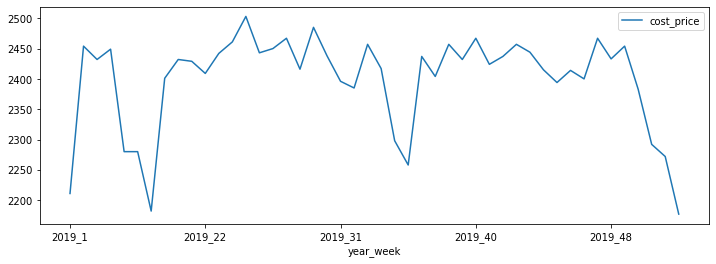

In [49]:
dfstock[dfstock.SKU == 10060].plot(x='year_week', y = 'cost_price', figsize=(12, 4))

In [65]:
dftr.columns

Index(['dates', 'SKU', 'user', 'price'], dtype='object')

<AxesSubplot:xlabel='dates'>

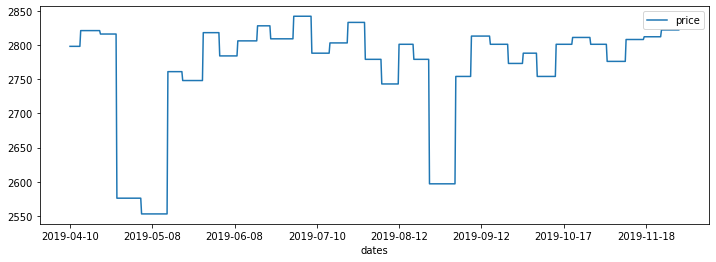

In [66]:
dftr[dftr.SKU == 10060].plot(x='dates', y = 'price', figsize=(12, 4))

In [67]:
dfcp.columns

Index(['year', 'week_num', 'SKU', 'ret_net_1_price', 'ret_net_2_price',
       'ret_net_3_price', 'year_week'],
      dtype='object')

### Plan

In [ ]:
# прогнозируемом отрезке времени (декабрь 2019 года).
# last transaction 2019-04-21

In [10]:
def calculate_regret(env: BernoulliEnv, strategy: Strategy, n_iters=2000):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    for i in range(n_iters):
        reward = bandit.strategy.arms_actions.dot(env.arms_proba)
        optimal_reward = np.max(env.arms_proba) * i
        regret = optimal_reward - reward
        regrets.append(regret)
        bandit.action()
        
    return regrets

In [ ]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1')
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2')
plt.legend()

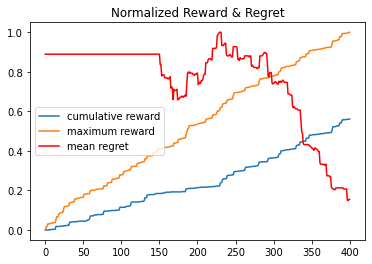

In [32]:
from space_bandits import LinearBandits
 
num_actions = 3 # num of available models (promo strategies)
num_features = 2 # num of features per customer

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_choices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate a customer
        cust = get_customer()
        
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        
        #prepare features for model
        context = np.array([cust[1]])
        best_choice = optimal_choices[cust[0]]
        
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        
        # make and action
        action = model.action(context)
        
        #get reward for the action chosen by model
        reward = reward_vec[action]
        
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            
records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)


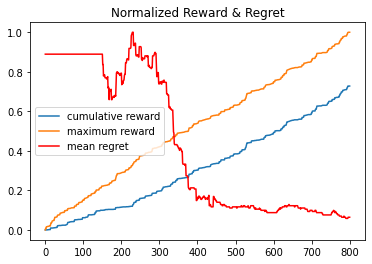

In [34]:
# from space_bandits import load_model
# linear_model.save('test_path.pkl')
# linear_model = load_model('test_path.pkl')

#continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

Давайте теперь для модели построим разделяющую прямую, которая делит 2 облака покупателей, на основании моделирования

/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


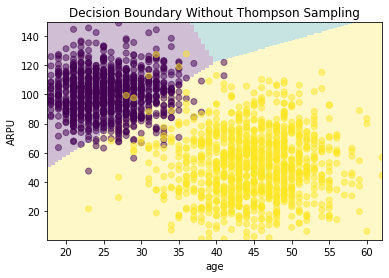

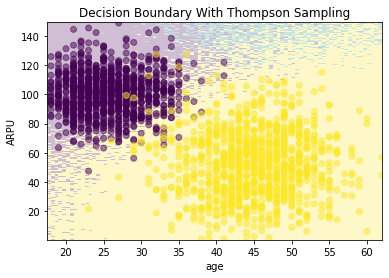

took  2.52  seconds.


In [22]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')